In [53]:
import os
import numpy as np
import pandas as pd
import scprep
import sklearn
import scipy
import phate
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow_probability as tfp

# Data Preprocessing

In [2]:
rna_data = pd.read_pickle('/data/lab/datasets/Chaffer_2017_mammosphere/filtered_variables_ha/filtered_D30_rna_sqrt.pickle')
print(rna_data.shape)
atac_data = pd.read_csv('/data/lab/datasets/Chaffer_2017_mammosphere/scATAC/gene_activity/activity.matrix.chaffer2017.csv').transpose()
print(atac_data.shape)

(3323, 18642)
(6000, 19931)


In [25]:
atac_barcodes = atac_data.index.values
rna_tmp = rna_data.index.values
rna_barcodes = []
for r in rna_tmp:
    rna_barcodes.append(r[:-2] + '.' + r[-1])
atac_genes = atac_data.columns.values
rna_genes = rna_data.columns.values
print('{} common genes'.format(len(set(atac_genes).intersection(set(rna_genes)))))
print('{} common barcodes'.format(len(set(atac_barcodes).intersection(set(rna_barcodes)))))

14470 common genes
0 common barcodes


In [14]:
expressed_genes = np.where(np.sum(rna_data, axis=0) > 0)[0]
rna_data = rna_data.to_numpy()[:,expressed_genes]
rna_data = scprep.normalize.batch_mean_center(rna_data)

In [ ]:
expressed_genes = np.where(np.sum(atac_data, axis=0) > 0)[0]
atac_data = atac_data.to_numpy()[:,expressed_genes]
atac_data = scprep.normalize.library_size_normalize(atac_data, rescale=1000)
atac_data = scprep.transform.sqrt(atac_data)
atac_data = scprep.normalize.batch_mean_center(atac_data)
atac_data = scipy.stats.zscore(atac_data)

In [57]:
np.savez_compressed('/home/anniegao/spatial_magan/data/scicar_rna_data', rna_data)
np.savez_compressed('/home/anniegao/spatial_magan/data/scicar_atac_data', atac_data)

In [28]:
rna_pca = sklearn.decomposition.PCA()
rna_pca.fit(rna_data)
rna_reduced = rna_data @ rna_pca.components_[:100, :].T
print(rna_reduced.shape)

(3323, 100)


In [39]:
np.savez_compressed('/home/anniegao/spatial_magan/data/scicar_rna_pca_100components', rna_pca.components_[:100, :])
np.savez_compressed('/home/anniegao/spatial_magan/data/scicar_rna_pca', rna_reduced)

In [58]:
atac_pca = sklearn.decomposition.PCA()
atac_pca.fit(atac_data)
atac_reduced = atac_data @ atac_pca.components_[:100, :].T
print(atac_reduced.shape)

(6000, 100)


In [61]:
np.savez_compressed('/home/anniegao/spatial_magan/data/scicar_atac_pca_100components', atac_pca.components_[:100, :])
np.savez_compressed('/home/anniegao/spatial_magan/data/scicar_atac_pca', atac_reduced)

In [66]:
kde = scipy.stats.gaussian_kde(atac_pca.T)
p = 1 - kde.pdf(atac_pca.T)
p /= np.sum(p)
idx = np.random.choice(np.arange(atac_pca.shape[0]), size=3323, replace=False, p=p)
atac_sample = atac_pca[idx,:]
atac_labels_sample = atac_cluster_labels[idx]

In [71]:
atac_data_sample = atac_data[idx,:]
np.savez_compressed('/home/anniegao/spatial_magan/data/scicar_atac_data_sampled', atac_data_sample)
np.savez_compressed('/home/anniegao/spatial_magan/data/scicar_atac_sample_idx', idx)

In [67]:
np.savez_compressed('/home/anniegao/spatial_magan/data/scicar_atac_pca_sampled', atac_sample)
np.savez_compressed('/home/anniegao/spatial_magan/data/scicar_atac_cluster_4_labels_sampled', atac_labels_sample)

<AxesSubplot:>

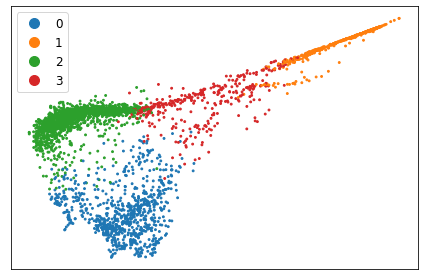

In [70]:
atac_phate_op = phate.PHATE(verbose=0)
atac_phate = atac_phate_op.fit_transform(atac_sample)
scprep.plot.scatter2d(atac_phate, fontsize=10, ticks=False, c=atac_labels_sample)

<AxesSubplot:>

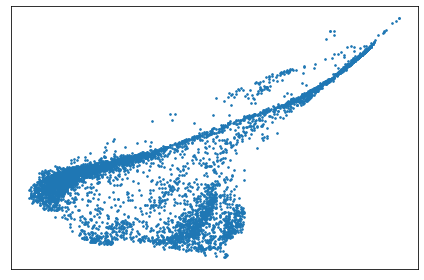

In [59]:
atac_phate_op = phate.PHATE(verbose=0)
atac_phate = atac_phate_op.fit_transform(atac_data)
scprep.plot.scatter2d(atac_phate, fontsize=10, ticks=False)

<AxesSubplot:>

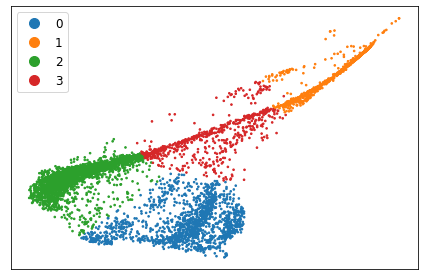

In [60]:
atac_phate_clusters = phate.cluster.kmeans(atac_phate_op, n_clusters=4)
scprep.plot.scatter2d(atac_phate, fontsize=10, ticks=False, c=atac_phate_clusters)

In [62]:
np.savez_compressed('/home/anniegao/spatial_magan/data/scicar_atac_cluster_4_labels_phate', atac_phate_clusters)

<AxesSubplot:>

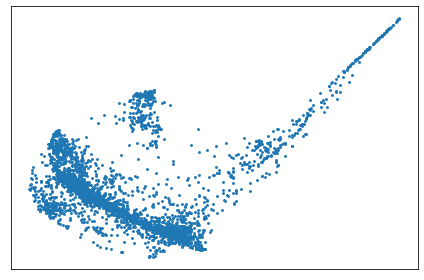

In [35]:
rna_phate_op = phate.PHATE(verbose=0)
rna_phate = rna_phate_op.fit_transform(rna_data)
scprep.plot.scatter2d(rna_phate, fontsize=10, ticks=False)

<AxesSubplot:>

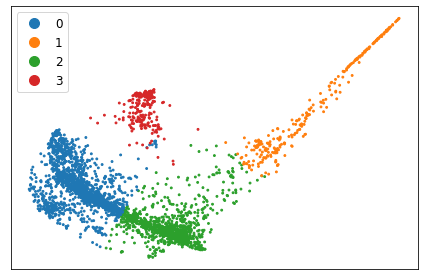

In [36]:
rna_phate_clusters = phate.cluster.kmeans(rna_phate_op, n_clusters=4)
scprep.plot.scatter2d(rna_phate, fontsize=10, ticks=False, c=rna_phate_clusters)

In [38]:
np.savez_compressed('/home/anniegao/spatial_magan/data/scicar_rna_cluster_4_labels_phate', rna_phate_clusters)


# MAGAN Results

In [72]:
rna_data = np.load('/home/anniegao/spatial_magan/data/scicar_rna_data.npz')['arr_0']
print(rna_data.shape)
rna_pca = np.load('/home/anniegao/spatial_magan/data/scicar_rna_pca.npz')['arr_0']
print(rna_pca.shape)
rna_cluster_labels = np.load('/home/anniegao/spatial_magan/data/scicar_rna_cluster_4_labels_phate.npz')['arr_0']
print(rna_cluster_labels.shape)
rna_pcs = np.load('/home/anniegao/spatial_magan/data/scicar_rna_pca_100components.npz')['arr_0']
print(rna_pcs.shape)

atac_data = np.load('/home/anniegao/spatial_magan/data/scicar_atac_data_sampled.npz')['arr_0']
print(atac_data.shape)
atac_pca = np.load('/home/anniegao/spatial_magan/data/scicar_atac_pca_sampled.npz')['arr_0']
print(atac_pca.shape)
atac_cluster_labels = np.load('/home/anniegao/spatial_magan/data/scicar_atac_cluster_4_labels_sampled.npz')['arr_0']
print(atac_cluster_labels.shape)
atac_pcs = np.load('/home/anniegao/spatial_magan/data/scicar_atac_pca_100components.npz')['arr_0']
print(atac_pcs.shape)

(3323, 18639)
(3323, 100)
(3323,)
(100, 18639)
(3323, 19920)
(3323, 100)
(3323,)
(100, 19920)


In [41]:
import sys
sys.path.append(os.path.join(os.getcwd(), 'MAGAN/MAGAN'))
from model import MAGAN

Instructions for updating:
non-resource variables are not supported in the long term


In [73]:
phate_op = phate.PHATE(verbose=0)
rna_phate = phate_op.fit_transform(rna_pca)
atac_phate = phate_op.fit_transform(atac_pca)

In [43]:
def analyze_results(model_num, magan_viz_iters, phate_op=phate.PHATE(verbose=0)):
    magan = MAGAN(dim_b1=rna_pca.shape[1], dim_b2=atac_pca.shape[1], correspondence_loss=None, xb1_pcs=None, xb2_pcs=None, restore_folder='/home/anniegao/spatial_magan/MAGAN/MAGAN/scicar_models/model{}'.format(model_num))
    atac_to_rna = magan.get_layer(rna_pca, atac_pca, 'Gb1')  # 2->1
    rna_to_atac = magan.get_layer(rna_pca, atac_pca, 'Gb2')  # 1->2
    
    # visualize magan plots
    fig, axes = plt.subplots(2,2,figsize=(20,20))
    axes[0,0].imshow(mpimg.imread('MAGAN/MAGAN/scicar_models/model{}/plots/plot_{}.png'.format(model_num, magan_viz_iters[0])))
    axes[0,1].imshow(mpimg.imread('MAGAN/MAGAN/scicar_models/model{}/plots/plot_{}.png'.format(model_num, magan_viz_iters[1])))
    axes[1,0].imshow(mpimg.imread('MAGAN/MAGAN/scicar_models/model{}/plots/plot_{}.png'.format(model_num, magan_viz_iters[2])))
    axes[1,1].imshow(mpimg.imread('MAGAN/MAGAN/scicar_models/model{}/plots/plot_{}.png'.format(model_num, magan_viz_iters[3])))
    axes[0,0].set_title('{} Iterations'.format(magan_viz_iters[0]))
    axes[0,1].set_title('{} Iterations'.format(magan_viz_iters[1]))
    axes[1,0].set_title('{} Iterations'.format(magan_viz_iters[2]))
    axes[1,1].set_title('{} Iterations'.format(magan_viz_iters[3]))
    plt.show()

    # gen kde plots
    column_names = ['c1','c2','c3','c4','c5']
    rna_df = pd.DataFrame(data=rna_pca[:,:5], columns=column_names)
    atac_to_rna_df = pd.DataFrame(data=atac_to_rna[:,:5], columns = column_names)
    atac_df = pd.DataFrame(data=atac_pca[:,:5], columns=column_names)
    rna_to_atac_df = pd.DataFrame(data=rna_to_atac[:,:5], columns=column_names)
    fig, axes = plt.subplots(2, 2, figsize=(10,10))
    for i in range(5):
        sns.kdeplot(data=rna_df['c{}'.format(i+1)], ax=axes[0,0])
        sns.kdeplot(data=atac_to_rna_df['c{}'.format(i+1)], ax=axes[0,1])
        sns.kdeplot(data=atac_df['c{}'.format(i+1)], ax=axes[1,0])
        sns.kdeplot(data=rna_to_atac_df['c{}'.format(i+1)], ax=axes[1,1])
    for i in range(2):
        for j in range(2):
            axes[i,j].set_xlabel('Data')
            axes[i,j].set_ylabel('Density')
            axes[i,j].set_xlim(left=-10, right=10)
    axes[0,0].set_title('RNA PCA Density')
    axes[0,1].set_title('ATAC->RNA Density')
    axes[1,0].set_title('ATAC PCA Density')
    axes[1,1].set_title('RNA->ATAC PCA Density')
    plt.show()
    
    # gen phate plots
    atac_to_rna_phate = phate_op.fit_transform(atac_to_rna)
    rna_to_atac_phate = phate_op.fit_transform(rna_to_atac)
    fig, axes = plt.subplots(2,2, figsize=(15,10))
    scprep.plot.scatter2d(rna_phate, fontsize=10, ticks=False, ax=axes[0,0], c=rna_cluster_labels)
    scprep.plot.scatter2d(atac_to_rna_phate, fontsize=10, ticks=False, ax=axes[0,1], c=atac_cluster_labels)
    scprep.plot.scatter2d(atac_phate, fontsize=10, ticks=False, ax=axes[1,0], c=atac_cluster_labels)
    scprep.plot.scatter2d(rna_to_atac_phate, fontsize=10, ticks=False, ax=axes[1,1], c=rna_cluster_labels)
    axes[0,0].set_title('Original RNA Data')
    axes[0,1].set_title('Generated ATAC->RNA Data')
    axes[1,0].set_title('Original ATAC Data')
    axes[1,1].set_title('Generated RNA->ATAC Data')
    plt.show()

In [78]:
def print_correlations(model_num, num_sig_genes):
    magan = MAGAN(dim_b1=rna_pca.shape[1], dim_b2=atac_pca.shape[1], correspondence_loss=None, xb1_pcs=None, xb2_pcs=None, restore_folder='/home/anniegao/spatial_magan/MAGAN/MAGAN/scicar_models/model{}'.format(model_num))
    atac_to_rna = magan.get_layer(rna_pca, atac_pca, 'Gb1')  # 2->1
    rna_to_atac = magan.get_layer(rna_pca, atac_pca, 'Gb2')  # 1->2
    
    rna_recon = atac_to_rna @ rna_pcs
    atac_recon = rna_to_atac @ atac_pcs
    rna_corr = rna_to_atac @ rna_pcs
    atac_corr = atac_to_rna @ atac_pcs
    rna_sig_genes = scprep.stats.differential_expression_by_cluster(rna_data, rna_cluster_labels)
    atac_sig_genes = scprep.stats.differential_expression_by_cluster(atac_data, atac_cluster_labels)
    print('Correlations using top {} significant genes'.format(num_sig_genes))
    
    rna_corrs_cell = []
    rna_corrs_gene = []
    for i in range(4):
        top_20_rna = rna_sig_genes[i].index[:num_sig_genes]
        s1 = rna_data[:,top_20_rna]
        s2 = rna_corr[:,top_20_rna]
        corr_cell = tfp.stats.correlation(s1, s2, sample_axis=1, event_axis=None)
        corr_cell_arr = corr_cell.eval(session=tf.compat.v1.Session())
        corr_gene = tfp.stats.correlation(s1, s2, sample_axis=0, event_axis=None)
        corr_gene_arr = corr_gene.eval(session=tf.compat.v1.Session())
        rna_corrs_cell.append(np.mean(np.abs(corr_cell_arr)))
        rna_corrs_gene.append(np.mean(np.abs(corr_gene_arr)))
    print('Correlations by cluster by cell')
    print(rna_corrs_cell)
    print('Correlations by cluster by gene')
    print(rna_corrs_gene)
    
    atac_corrs_cell = []
    atac_corrs_gene = []
    for i in range(4):
        top_20_atac = atac_sig_genes[i].index[:num_sig_genes]
        s1 = atac_data[:,top_20_atac]
        s2 = atac_corr[:,top_20_atac]
        corr_cell = tfp.stats.correlation(s1, s2, sample_axis=1, event_axis=None)
        corr_cell_arr = corr_cell.eval(session=tf.compat.v1.Session())
        corr_gene = tfp.stats.correlation(s1, s2, sample_axis=0, event_axis=None)
        corr_gene_arr = corr_gene.eval(session=tf.compat.v1.Session())
        atac_corrs_cell.append(np.mean(np.abs(corr_cell_arr)))
        atac_corrs_gene.append(np.mean(np.abs(corr_gene_arr)))
    print('Correlations by cluster by cell')
    print(atac_corrs_cell)
    print('Correlations by cluster by gene')
    print(atac_corrs_gene)

INFO:tensorflow:Restoring parameters from /home/anniegao/spatial_magan/MAGAN/MAGAN/scicar_models/model1/MAGAN_model_9999
Model restored from /home/anniegao/spatial_magan/MAGAN/MAGAN/scicar_models/model1


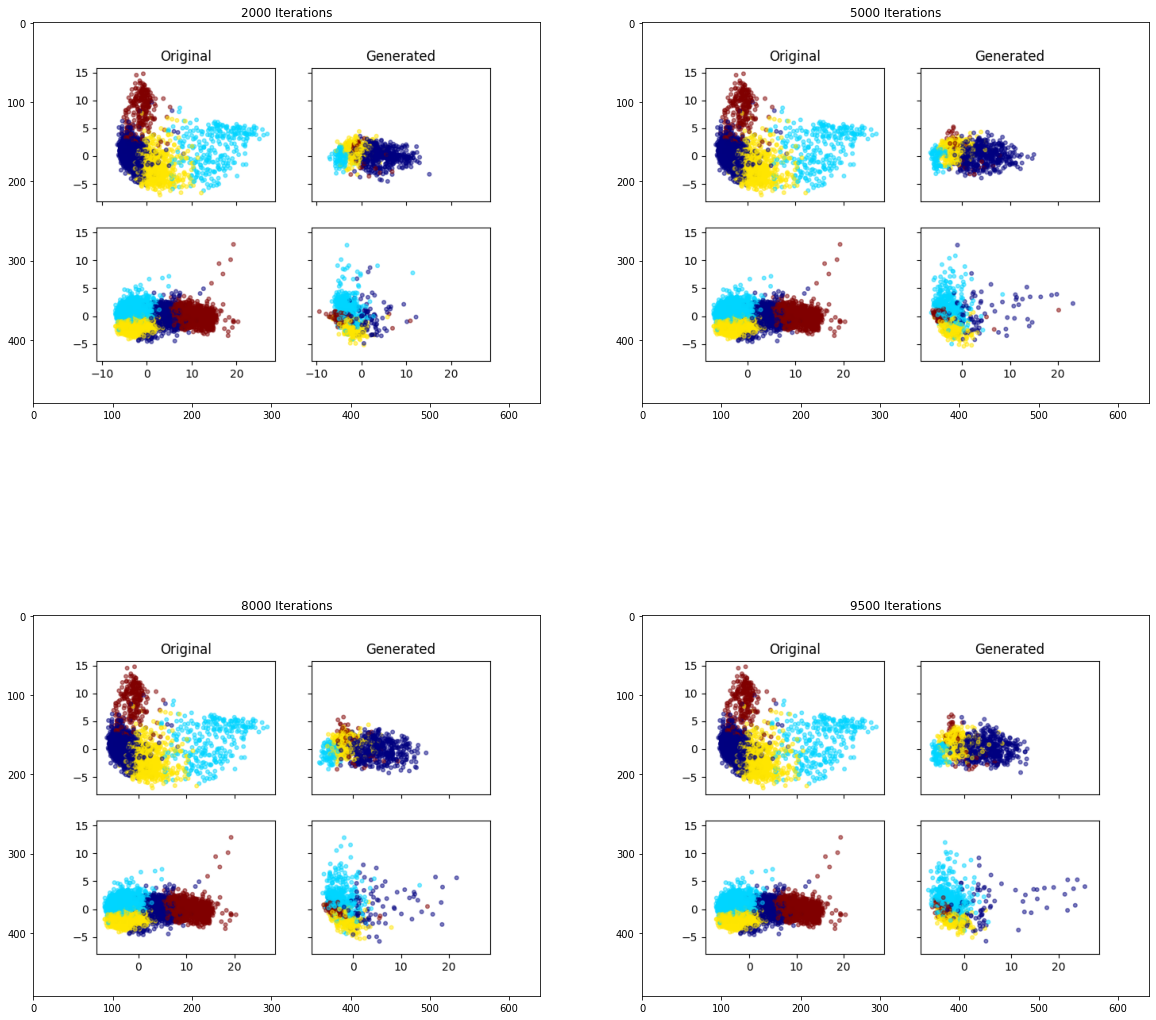

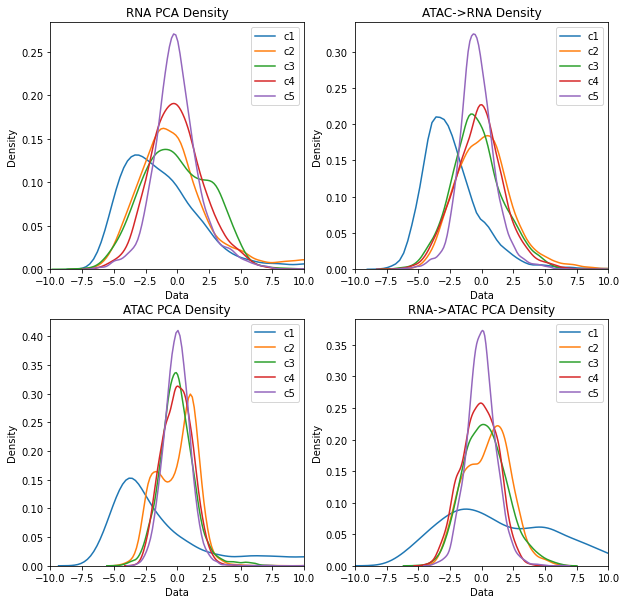

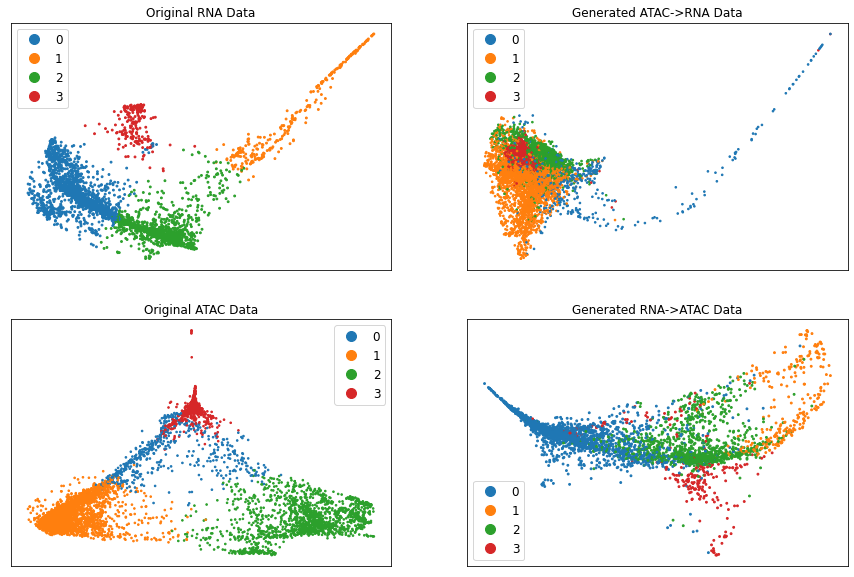

In [44]:
analyze_results(1, [2000, 5000, 8000, 9500])

In [52]:
print_correlations(1, 20)

INFO:tensorflow:Restoring parameters from /home/anniegao/spatial_magan/MAGAN/MAGAN/scicar_models/model1/MAGAN_model_9999
Model restored from /home/anniegao/spatial_magan/MAGAN/MAGAN/scicar_models/model1
Correlations using top 20 significant genes
Correlations by cluster by cell
[0.8585183248705625, 0.8329358308198596, 0.8256427607269438, 0.8190465977886466]
Correlations by cluster by gene
[0.6394456317970167, 0.6104511853934553, 0.5909070229508945, 0.479643780990997]
Correlations by cluster by cell
[0.2810266136351182, 0.3361345793895657, 0.5064334541013721, 0.2958809080091382]
Correlations by cluster by gene
[0.13997964487136244, 0.34924569880286727, 0.2846863923679177, 0.07846362033842239]


INFO:tensorflow:Restoring parameters from /home/anniegao/spatial_magan/MAGAN/MAGAN/scicar_models/model2/MAGAN_model_9999
Model restored from /home/anniegao/spatial_magan/MAGAN/MAGAN/scicar_models/model2


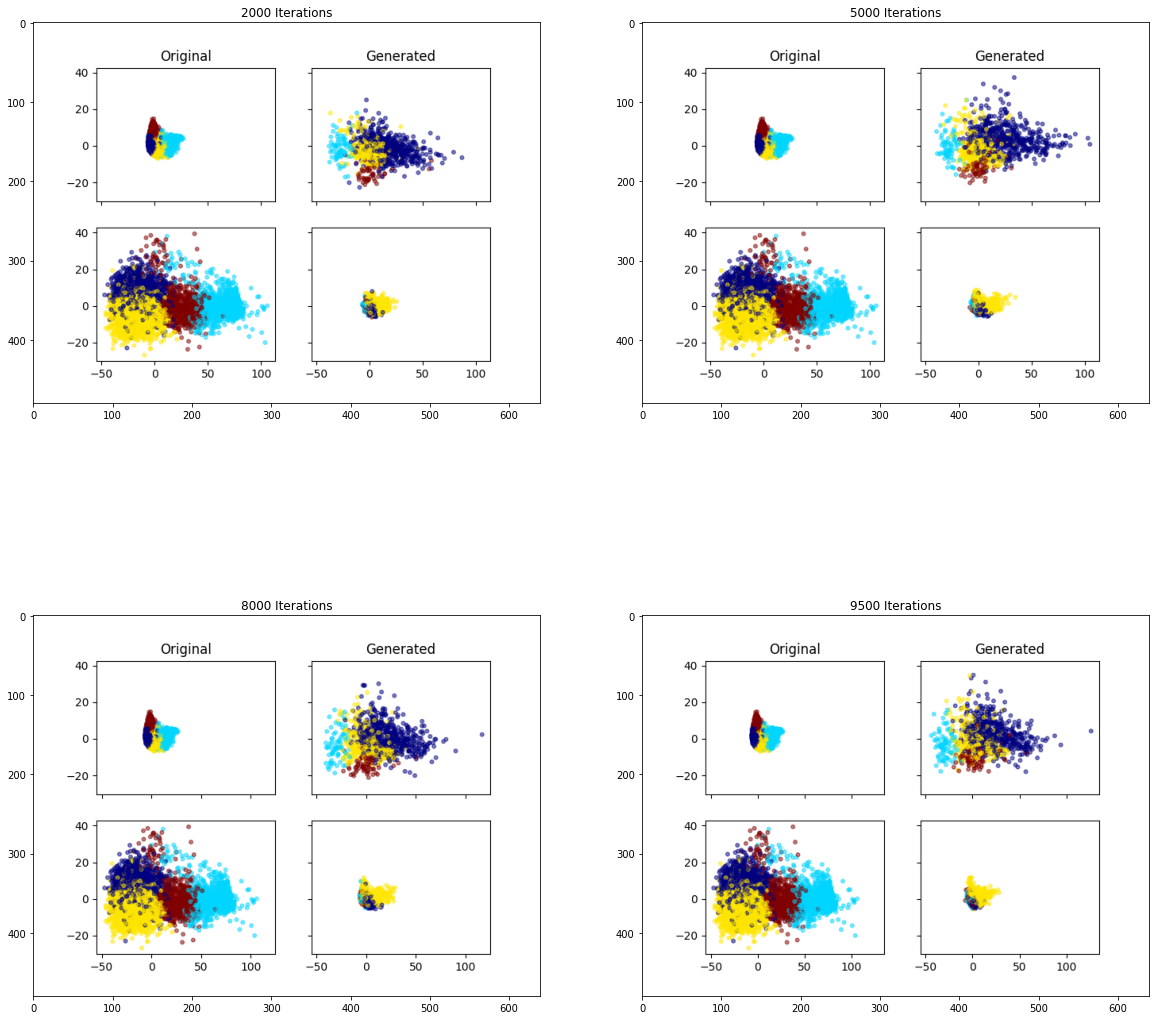

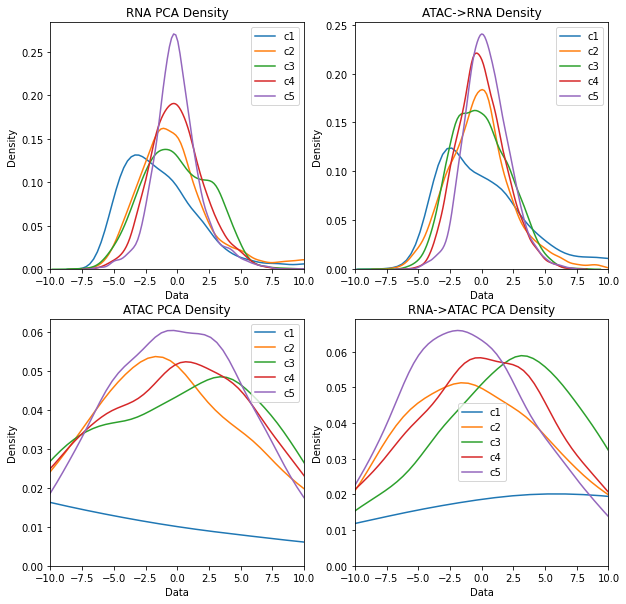

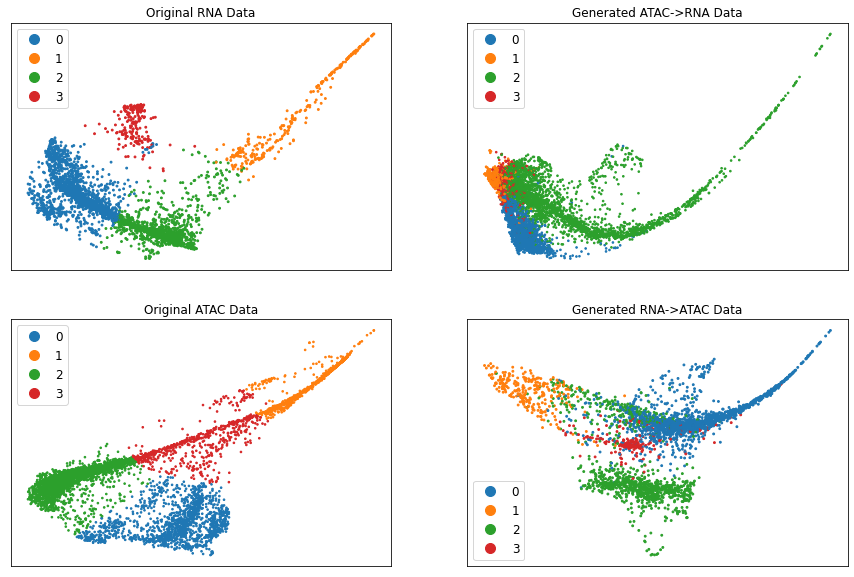

In [65]:
analyze_results(2, [2000, 5000, 8000, 9500])

In [79]:
print_correlations(2, 20)

INFO:tensorflow:Restoring parameters from /home/anniegao/spatial_magan/MAGAN/MAGAN/scicar_models/model2/MAGAN_model_9999
Model restored from /home/anniegao/spatial_magan/MAGAN/MAGAN/scicar_models/model2
Correlations using top 20 significant genes
Correlations by cluster by cell
[0.8211037320778508, 0.787742868760734, 0.8094645709247197, 0.8021135840302808]
Correlations by cluster by gene
[0.5322092951125692, 0.5106535133335474, 0.3375863457648367, 0.5125026539285056]
Correlations by cluster by cell
[0.4135923057268864, 0.2610377882627661, 0.2862905623054243, 0.24073770715995607]
Correlations by cluster by gene
[0.40055945446897656, 0.3081186629382312, 0.4068250355226376, 0.24983229535521678]


INFO:tensorflow:Restoring parameters from /home/anniegao/spatial_magan/MAGAN/MAGAN/scicar_models/model3/MAGAN_model_9999
Model restored from /home/anniegao/spatial_magan/MAGAN/MAGAN/scicar_models/model3


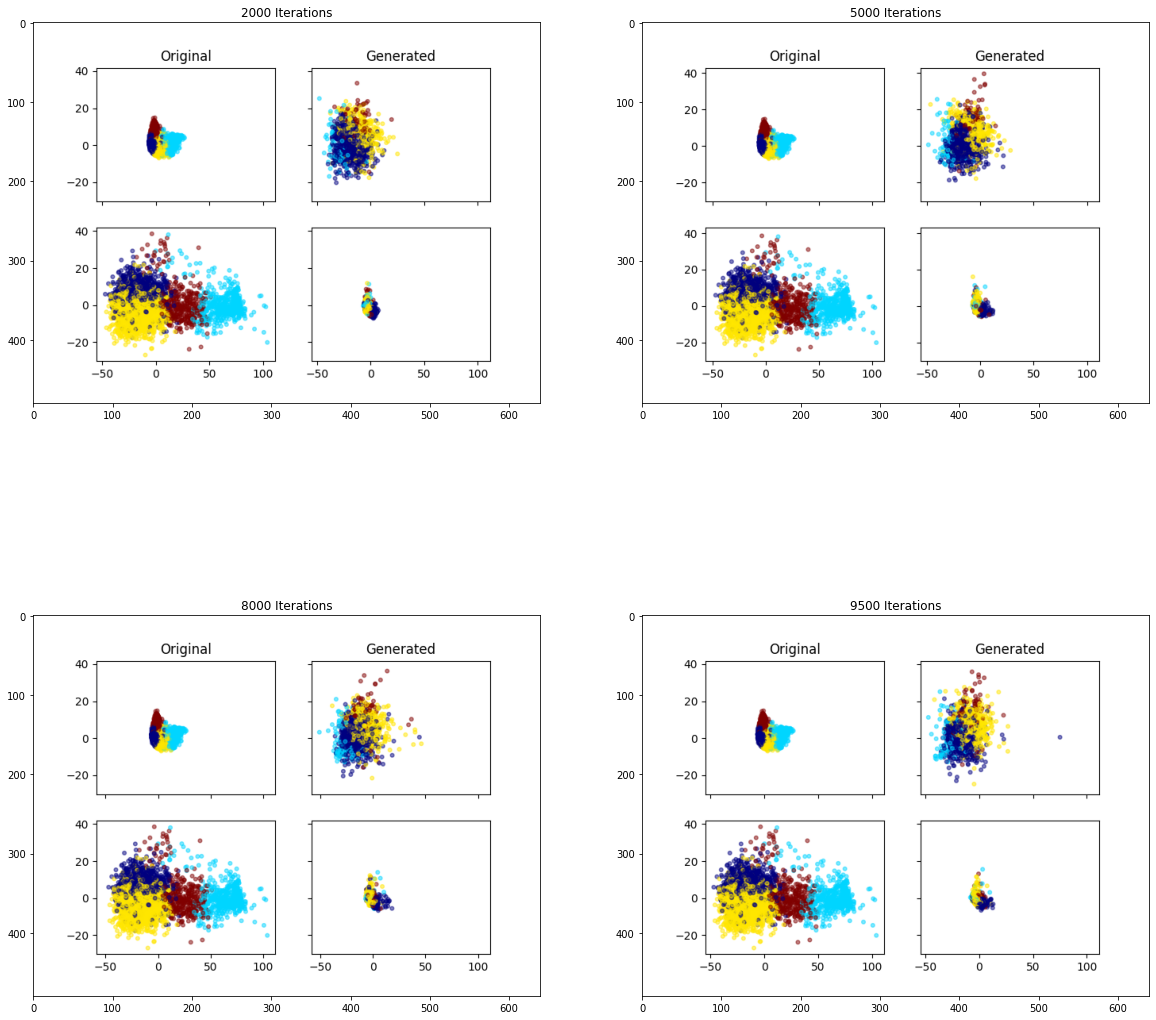

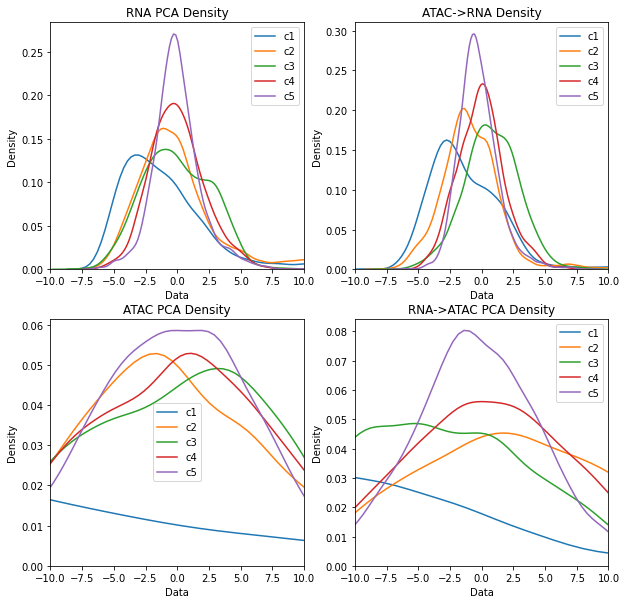

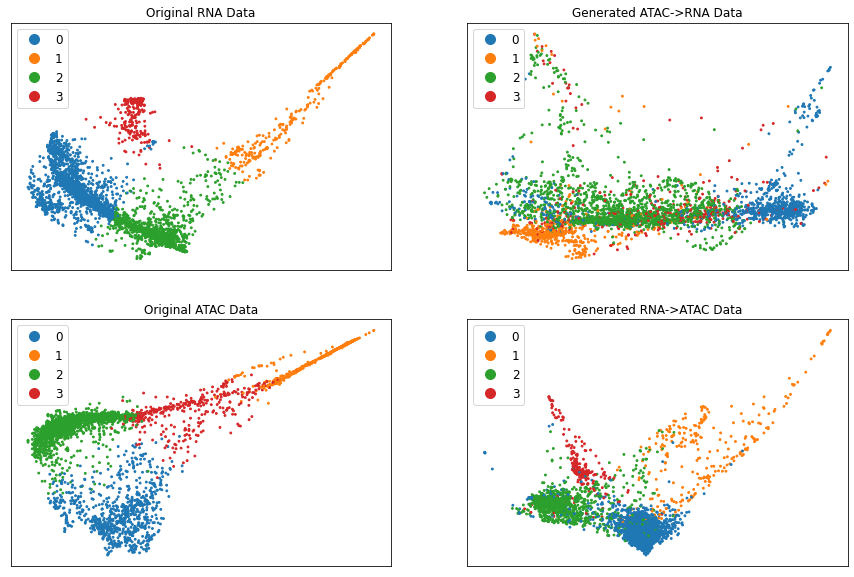

In [75]:
analyze_results(3, [2000, 5000, 8000, 9500])